In [1]:
import os
import re
import json
import pickle
from pathlib import Path
import yaml

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy
import skimage
import pandas as pd
import torch
import torchvision
import tifffile
from sklearn.metrics import adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram
from einops import rearrange, repeat

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils
import mushroom.data.datasets as datasets
import mushroom.data.visium as visium
import mushroom.data.xenium as xenium
import mushroom.data.multiplex as multiplex
import mushroom.data.he as he
import mushroom.registration.bigwarp as bigwarp
from mushroom.mushroom import Mushroom

In [6]:
project_dir = Path('/data/estorrs/mushroom/data/projects/submission_v1')
output_dir = project_dir / 'analysis' / 'nbhd_characterization'
output_dir.mkdir(parents=True, exist_ok=True)

In [7]:
source_root = '/diskmnt/Projects/Users/estorrs/mushroom/data'
target_root = '/data/estorrs/mushroom/data'

def alter_filesystem(config, source_root, target_root):
    for entry in config['sections']:
        for mapping in entry['data']:
            mapping['filepath'] = mapping['filepath'].replace(source_root, target_root)
    
    if 'trainer_kwargs' in config and config['trainer_kwargs']['data_mask'] is not None:
        config['trainer_kwargs']['data_mask'] = config['trainer_kwargs']['data_mask'].replace(source_root, target_root)
        
    return config

In [8]:
case_order = [
    'HT206B1',
    'HT268B1',
    'HT339B2-H1',
    'HT397B1',
    'HT565B1-H2',
    'HT704B1',
    'HT891Z1',
    'HT913Z1',
    'S18-5591-C8',
    'S18-9906',
]

In [9]:
fps = sorted(utils.listfiles(project_dir, regex=r'mushroom_50res/config.yaml$'))
fps = [fp for fp in fps if fp.split('/')[-3] in case_order]
fps

['/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT268B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT339B2-H1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT565B1-H2/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT891Z1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT913Z1/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/S18-5591-C8/mushroom_50res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/S18-9906/mushroom_50res/config.yaml']

In [10]:
case_to_sections = {fp.split('/')[-3]:yaml.safe_load(open(fp))['sections'] for fp in fps}
case_to_sections.keys()

dict_keys(['HT206B1', 'HT268B1', 'HT339B2-H1', 'HT397B1', 'HT565B1-H2', 'HT704B1', 'HT891Z1', 'HT913Z1', 'S18-5591-C8', 'S18-9906'])

In [11]:
case_to_labeled_slice = {}
for case in case_order:
    data = pickle.load(
        open(project_dir / case / 'mushroom_50res' / f'nbhd_volumes_l1.pkl', 'rb')
    )
    volume = data['labeled']['integrated']
    print(case, volume.shape)
    labeled = volume[1]
    case_to_labeled_slice[case] = labeled

HT206B1 (25, 132, 124)
HT268B1 (32, 132, 132)
HT339B2-H1 (2, 132, 132)
HT397B1 (31, 132, 132)
HT565B1-H2 (2, 132, 132)
HT704B1 (93, 148, 180)
HT891Z1 (116, 132, 148)
HT913Z1 (125, 132, 172)
S18-5591-C8 (24, 164, 228)
S18-9906 (33, 172, 172)


In [12]:
def get_nbhd_rgb(case, nbhds, cmap=None):
    labeled = case_to_labeled_slice[case].copy()
    
    rgb = vis_utils.display_labeled_as_rgb(labeled, cmap=cmap)
    
    m = np.zeros_like(labeled, dtype=bool)
    for l in nbhds:
        m |= labeled==l
    
    rgb[~m] = 0.
    
    return rgb

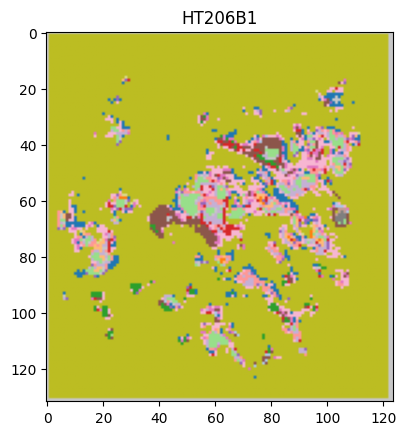

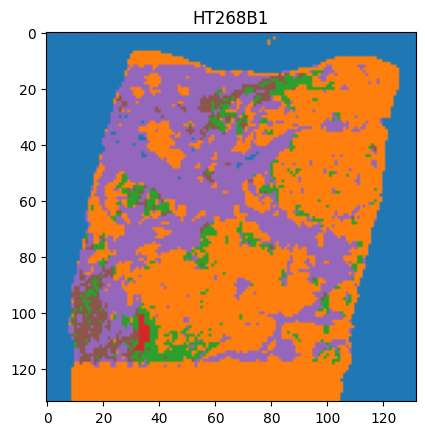

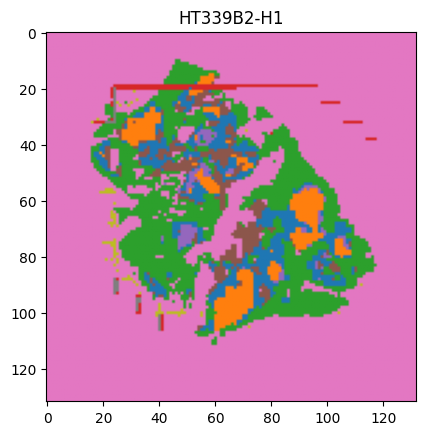

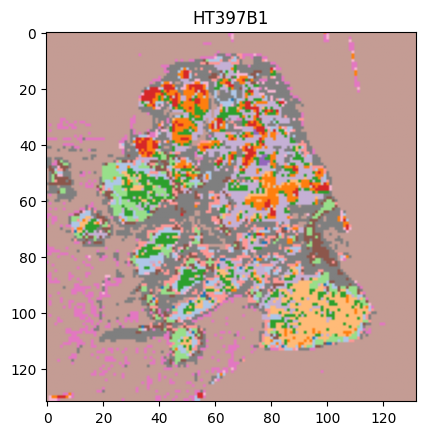

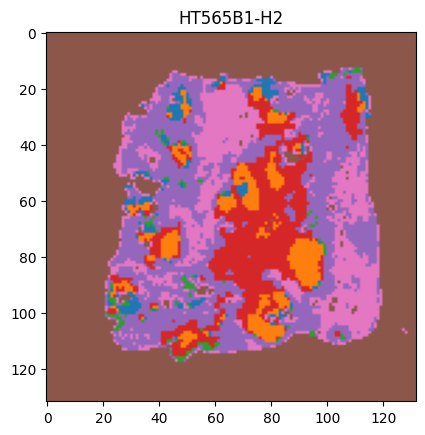

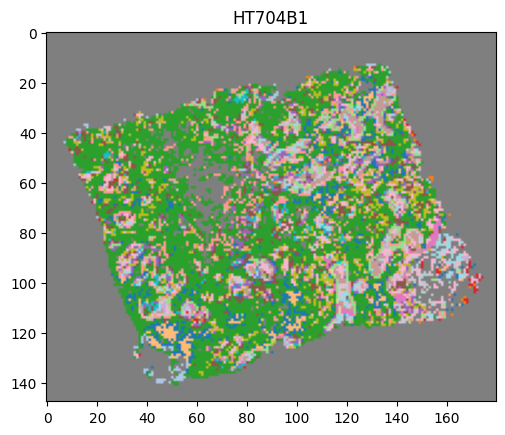

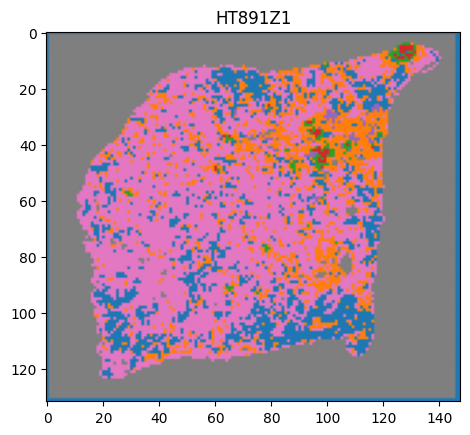

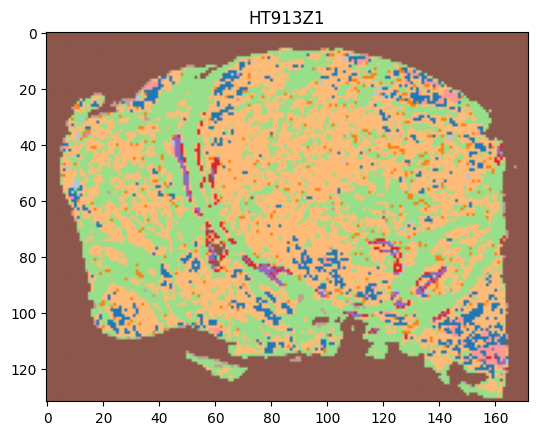

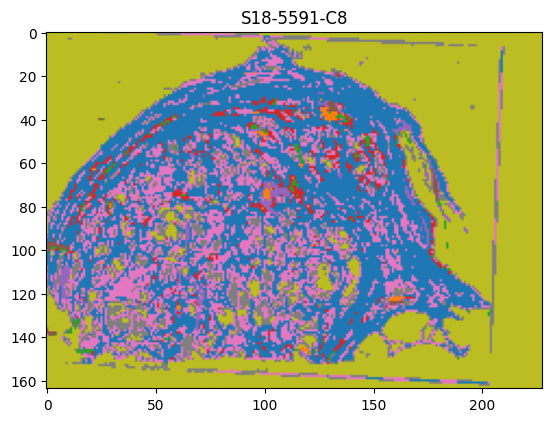

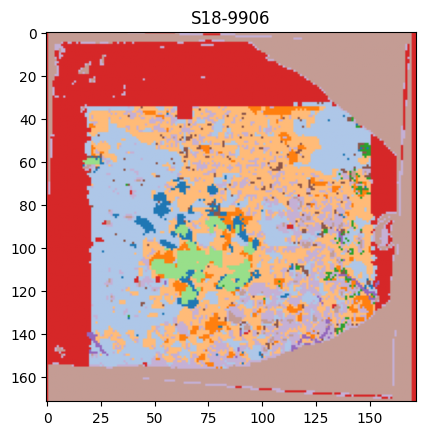

In [13]:
for case, labeled in case_to_labeled_slice.items():
    rgb = get_nbhd_rgb(case, labeled)
    plt.imshow(rgb)
    plt.title(case)
    plt.show()

## quantify neighborhood composition

#### save intensity data

In [45]:
import warnings
import anndata
warnings.filterwarnings("ignore", category=anndata.ImplicitModificationWarning)

def get_sid_to_intensities(case):
    imaris_dir = project_dir / case / 'imaris' / 'rois'
    config = yaml.safe_load(open(project_dir / case / 'registered' / 'metadata.yaml'))
    config = alter_filesystem(config, source_root, target_root)
    
    meta = json.load(open(imaris_dir / 'tiled' / 'metadata.json'))

    sid_to_channels = meta['sid_to_channels']
    dtype_ident_to_dtype = meta['dtype_ident_to_dtype']
    dtype_ident_to_channels = meta['dtype_ident_to_channels']
    sid_to_dtype_ident = meta['sid_to_dtype_ident']
    tiling_size = meta['tiling_size']
    size = meta['size']
    fullres_size = meta['fullres_size']
    dtype_ident_to_tiled_fps = meta['dtype_ident_to_tiled_fps']
    
    dtype_ident_to_tiled = {dti:tifffile.imread(fp) for dti, fp in dtype_ident_to_tiled_fps.items()}
    for dti, tiled in dtype_ident_to_tiled.items():
        print(dti, tiled.shape)
    
    sid_to_tiled_idx = {}
    for dtype_ident in dtype_ident_to_channels.keys():
        if 'vis' not in dtype_ident:
            dtype = dtype_ident_to_dtype[dtype_ident]
            sids = [entry['sid'] for entry in config['sections'] if sid_to_dtype_ident[entry['sid']]==dtype_ident]
            for i, sid in enumerate(sids):
                sid_to_tiled_idx[sid] = i

    meta_ct = json.load(open(imaris_dir / 'tiled_cell_types' / 'metadata.json'))

    sid_to_channels_ct = meta_ct['sid_to_channels']
    dtype_ident_to_dtype_ct = meta_ct['dtype_ident_to_dtype']
    dtype_ident_to_channels_ct = meta_ct['dtype_ident_to_channels']
    sid_to_dtype_ident_ct = meta_ct['sid_to_dtype_ident']
    dtype_ident_to_tiled_fps_ct = meta_ct['dtype_ident_to_tiled_fps']
    
    dtype_ident_to_tiled_ct = {dti:tifffile.imread(fp) for dti, fp in dtype_ident_to_tiled_fps_ct.items()}
    for dti, tiled in dtype_ident_to_tiled_ct.items():
        print(dti, tiled.shape)
    
    sid_to_tiled_idx_ct = {}
    for dtype_ident in dtype_ident_to_channels_ct.keys():
        dtype = dtype_ident_to_dtype_ct[dtype_ident]
        sids = [entry['sid'] for entry in config['sections'] if sid_to_dtype_ident.get(entry['sid'])==dtype_ident]
        for i, sid in enumerate(sids):
            sid_to_tiled_idx_ct[sid] = i

    data = pickle.load(
        open(project_dir / case / 'mushroom_50res' / f'outputs.pkl', 'rb')
    )
    print(data['section_ids'])
    mushroom_config = yaml.safe_load(
        open(project_dir / case / 'mushroom_50res' / f'config.yaml', 'rb')
    )
    mushroom_res = mushroom_config['trainer_kwargs']['target_resolution']

    adata, nbhds = None, None
    sid_to_df, sid_to_dtype, sid_to_df_ct = {}, {}, {}
    for entry in config['sections']:
        sid = entry['sid']
        position = entry['position']
        dti = sid_to_dtype_ident[sid]
        channels = dtype_ident_to_channels[dti]
    
        fp, dtype = None, None
        for mapping in entry['data']:
            if mapping['dtype'] in dti:
                fp = mapping['filepath']
                dtype = mapping['dtype']
        assert fp is not None
        sid_to_dtype[sid] = dtype
        
        tups = [x for x in data['section_ids'] if x[1] == dtype]
        if (sid, dtype) not in tups:
            continue

        idx = tups.index((sid, dtype))
        nbhds = data['dtype_to_clusters'][dtype][-1][idx]
        # print(sid, dti, nbhds.shape, fp)
    
        if dti in dtype_ident_to_tiled:
            tiled = dtype_ident_to_tiled[dti][sid_to_tiled_idx[sid]]
            nbhds = utils.rescale(nbhds, size=tiled.shape[1:], dim_order='h w', target_dtype=nbhds.dtype,
                                  antialias=False, interpolation=torchvision.transforms.InterpolationMode.NEAREST)
            datas, indices = [], np.unique(nbhds)
            for nbhd in indices:
                mask = nbhds == nbhd
                means = tiled[..., mask].mean(1)
                datas.append(means)
        elif dtype == 'visium':
            adata = sc.read_h5ad(fp)
            adata.var_names_make_unique()
            adata = adata[:, channels]
            adata.obs['tmp'] = 0 # need to initialize view for some reason
            if dtype == 'visium': # put coordinates in same spot as hd
                adata.obs['y_location'] = adata.obsm['spatial'][:, 1]
                adata.obs['x_location'] = adata.obsm['spatial'][:, 0]
    
            adata.obs['y_down'] = (adata.obs['y_location'] / mushroom_res).astype(int)
            adata.obs['x_down'] = (adata.obs['x_location'] / mushroom_res).astype(int)
    
            m = adata.obs['y_down'] < nbhds.shape[0]
            m &= adata.obs['x_down'] < nbhds.shape[1]
            adata = adata[m]
            
            adata.obs['nbhd'] = [nbhds[r, c] for r, c in zip(adata.obs['y_down'], adata.obs['x_down'])]
    
            datas, indices = [], np.unique(nbhds)
            for nbhd in indices:
                f = adata[adata.obs['nbhd']==nbhd]
                means = np.asarray(f.X.mean(0))
                datas.append(means)
        df = pd.DataFrame(data=datas, index=indices, columns=channels)
        sid_to_df[sid] = df

        if sid in sid_to_tiled_idx_ct:
            dti = sid_to_dtype_ident_ct[sid]
            tiled = dtype_ident_to_tiled_ct[dti][sid_to_tiled_idx_ct[sid]]
            nbhds = utils.rescale(nbhds, size=tiled.shape[1:], dim_order='h w', target_dtype=nbhds.dtype,
                                  antialias=False, interpolation=torchvision.transforms.InterpolationMode.NEAREST)
            datas, indices = [], np.unique(nbhds)
            for nbhd in indices:
                mask = nbhds == nbhd
                means = tiled[..., mask].mean(1)
                datas.append(means)
            df = pd.DataFrame(data=datas, index=indices, columns=dtype_ident_to_channels_ct[dti])
            sid_to_df_ct[sid] = df

    return sid_to_dtype, sid_to_df, sid_to_df_ct

In [47]:
case_to_data = {}
for case in case_order:
    print(case)
    config = yaml.safe_load(open(project_dir / case / 'registered' / 'metadata.yaml'))
    config = alter_filesystem(config, source_root, target_root)
    sid_to_dtype, sid_to_df, sid_to_df_ct = get_sid_to_intensities(case)
    case_to_data[case] = {
        'sid_to_dtype': sid_to_dtype,
        'sid_to_intensities': sid_to_df,
        'sid_to_cell_types': sid_to_df_ct,
        'config': config
    }

HT206B1
xenium_0 (3, 477, 653, 605)
he_0 (3, 3, 653, 605)
multiplex_0 (3, 37, 653, 605)
multiplex_1 (3, 38, 653, 605)
xenium_1 (3, 377, 653, 605)
xenium_0 (6, 14, 653, 605)
multiplex_0 (6, 6, 653, 605)
[('HT206B1-U1', 'xenium'), ('HT206B1-U2', 'multiplex'), ('HT206B1-U4', 'he'), ('HT206B1-U5', 'multiplex'), ('HT206B1-U8', 'xenium'), ('HT206B1-U9', 'xenium'), ('HT206B1-U10', 'multiplex'), ('HT206B1-U12', 'he'), ('HT206B1-U13', 'multiplex'), ('HT206B1-U16', 'xenium'), ('HT206B1-U17', 'xenium'), ('HT206B1-U18', 'multiplex'), ('HT206B1-U20', 'he'), ('HT206B1-U21', 'multiplex'), ('HT206B1-U24', 'xenium')]
HT268B1
visium_0 (4, 14, 677, 669)
[('HT268B1-U2', 'visium'), ('HT268B1-U2', 'he'), ('HT268B1-U12', 'visium'), ('HT268B1-U12', 'he'), ('HT268B1-U22', 'visium'), ('HT268B1-U22', 'he'), ('HT268B1-U32', 'visium'), ('HT268B1-U32', 'he')]


/tmp/ipykernel_1666122/1355352574.py:115: RuntimeWarning: Mean of empty slice.
  means = np.asarray(f.X.mean(0))
/data/estorrs/miniconda3/envs/mushroom_v2/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


HT339B2-H1
multiplex_0 (1, 33, 678, 668)
visium_0 (1, 11, 678, 668)
multiplex_0 (1, 6, 678, 668)
[('HT339B2-H1-U1', 'visium'), ('HT339B2-H1-U1', 'he'), ('HT339B2-H1-U2', 'multiplex')]
HT397B1
multiplex_0 (2, 25, 678, 669)
batch2_he_0 (6, 3, 678, 669)
multiplex_1 (1, 27, 678, 669)
multiplex_2 (1, 25, 678, 669)
visium_0 (2, 10, 678, 669)
multiplex_0 (4, 6, 678, 669)
[('HT397B1-U1', 'visium'), ('HT397B1-U1', 'he'), ('HT397B1-U2', 'multiplex'), ('HT397B1-U4', 'batch2_he'), ('HT397B1-U8', 'batch2_he'), ('HT397B1-U11', 'batch2_he'), ('HT397B1-U12', 'multiplex'), ('HT397B1-U16', 'batch2_he'), ('HT397B1-U21', 'visium'), ('HT397B1-U21', 'he'), ('HT397B1-U22', 'multiplex'), ('HT397B1-U20', 'batch2_he'), ('HT397B1-U28', 'batch2_he'), ('HT397B1-U31', 'multiplex')]
HT565B1-H2
multiplex_0 (1, 33, 678, 668)
visium_0 (1, 14, 678, 668)
multiplex_0 (1, 6, 678, 668)
[('HT565B1-H2-U1', 'visium'), ('HT565B1-H2-U1', 'he'), ('HT565B1-H2-U2', 'multiplex')]
HT704B1
xenium_0 (6, 476, 725, 906)
multiplex_0 (12, 

In [48]:
# case_to_data['HT206B1']['sid_to_cell_types']['HT206B1-U1']

In [49]:
# attempt to harmonize multiplex channels
mapping = {
    'keratin-5': 'ck5',
    'keratin-14': 'ck14',
}
pattern = r'[ -]?\(?[dD]\)?$'
def alter_name(x):
    x = re.sub(pattern, '', x)
    x = x.lower()
    x = x.replace(' ', '-')
    x = mapping.get(x, x)
    return x

sets = []
for case, data in case_to_data.items():
    config = data['config']
    sid_to_dtype = data['sid_to_dtype']
    sid_to_df = data['sid_to_intensities']
    for entry in config['sections']:
        sid = entry['sid']
        dtype = sid_to_dtype[sid]
    
        if dtype == 'multiplex' and sid in sid_to_df:
            df = sid_to_df[sid].copy()
            df.columns = [alter_name(c) for c in df.columns]
            sets.append(set(df.columns))

common = set.intersection(*sets)
potentials = sorted([x for x in set.union(*sets) if x not in common])
potentials

['a-amylase',
 'amacr',
 'ar',
 'bap1',
 'bca1',
 'cd11b',
 'cd163',
 'cd20',
 'cd39',
 'cd3e',
 'cd4',
 'cd44',
 'ck17',
 'ck19',
 'ck5',
 'ck7',
 'ck8/18',
 'ckit',
 'cox6c',
 'ctla4',
 'e-cadherin',
 'er',
 'foxp3',
 'gata3',
 'glut1',
 'granzyme-b',
 'hep-par-1',
 'her2',
 'hif1a',
 'lyve1',
 'mgp',
 'mlph',
 'p63',
 'pd-1',
 'plat/tpa',
 'pr',
 'slc39a6',
 'steap4',
 'tcf-1',
 'tff1']

In [50]:
for case, data in case_to_data.items():
    config = data['config']
    sid_to_dtype = data['sid_to_dtype']
    sid_to_df = data['sid_to_intensities']
    for entry in config['sections']:
        sid = entry['sid']
        dtype = sid_to_dtype[sid]
        if dtype == 'multiplex' and sid in sid_to_df:
            df = sid_to_df[sid]
            df.columns = [alter_name(c) for c in df.columns]
            sid_to_df[sid] = df

In [51]:
dtype_to_dfs = {}
for case, data in case_to_data.items():
    config = data['config']
    sid_to_dtype = data['sid_to_dtype']
    sid_to_df = data['sid_to_intensities']
    for entry in config['sections']:
        sid = entry['sid']
        dtype = sid_to_dtype[sid]
        if sid in sid_to_df:
            df = sid_to_df[sid].copy()
            df.index = [f'{case}_{sid}_{x}' for x in df.index.to_list()]
            if dtype not in dtype_to_dfs:
                dtype_to_dfs[dtype] = []
            dtype_to_dfs[dtype].append(df)
            

In [52]:
dtype_to_df = {dtype:pd.concat(dfs) for dtype, dfs in dtype_to_dfs.items()}
for dtype, df in dtype_to_df.items():
    print(dtype, df.shape)
    # df.to_csv(output_dir / f'intensities_{dtype}.txt.gz', sep='\t')
    

xenium (1271, 5228)
he (1722, 3)
multiplex (1573, 52)
visium (191, 36601)
batch2_he (210, 3)
cosmx (56, 1000)


In [53]:
for dtype in dtype_to_df:
    df = dtype_to_df[dtype]
    df['group'] = [x.split('_')[0] + '_' + x.split('_')[-1] for x in df.index.to_list()]
    df = df.groupby('group').mean()
    dtype_to_df[dtype] = df
    df.to_csv(output_dir / f'intensities_{dtype}.txt.gz', sep='\t')
    print(dtype, df.shape)

xenium (212, 5228)
he (96, 3)
multiplex (258, 52)
visium (100, 36601)
batch2_he (50, 3)
cosmx (28, 1000)


In [54]:
dtype_to_dfs = {}
for case, data in case_to_data.items():
    config = data['config']
    sid_to_dtype = data['sid_to_dtype']
    sid_to_df = data['sid_to_cell_types']
    for entry in config['sections']:
        sid = entry['sid']
        dtype = sid_to_dtype[sid]
        if sid in sid_to_df:
            df = sid_to_df[sid].copy()
            df.index = [f'{case}_{sid}_{x}' for x in df.index.to_list()]
            if dtype not in dtype_to_dfs:
                dtype_to_dfs[dtype] = []
            dtype_to_dfs[dtype].append(df)
dtype_to_df = {dtype:pd.concat(dfs) for dtype, dfs in dtype_to_dfs.items()}
for dtype, df in dtype_to_df.items():
    print(dtype, df.shape)

for dtype in dtype_to_df:
    df = dtype_to_df[dtype]
    df['group'] = [x.split('_')[0] + '_' + x.split('_')[-1] for x in df.index.to_list()]
    df = df.groupby('group').mean()
    dtype_to_df[dtype] = df
    df.to_csv(output_dir / f'celltypes_{dtype}.txt.gz', sep='\t')
    print(dtype, df.shape)  

xenium (964, 17)
multiplex (1442, 6)
visium (143, 14)
cosmx (56, 14)
xenium (203, 17)
multiplex (257, 6)
visium (75, 14)
cosmx (28, 14)


In [55]:
output_dir

PosixPath('/data/estorrs/mushroom/data/projects/submission_v1/analysis/nbhd_characterization')

#### identify neighborhoods

In [56]:
fps = sorted(utils.listfiles(output_dir, regex=r'celltypes.*txt.gz'))
fps

['/data/estorrs/mushroom/data/projects/submission_v1/analysis/nbhd_characterization/celltypes_cosmx.txt.gz',
 '/data/estorrs/mushroom/data/projects/submission_v1/analysis/nbhd_characterization/celltypes_multiplex.txt.gz',
 '/data/estorrs/mushroom/data/projects/submission_v1/analysis/nbhd_characterization/celltypes_visium.txt.gz',
 '/data/estorrs/mushroom/data/projects/submission_v1/analysis/nbhd_characterization/celltypes_xenium.txt.gz']

###### xenium

In [119]:
df = dtype_to_df['xenium']
adata = process_adata(df)
adata

AnnData object with n_obs × n_vars = 203 × 8
    obs: 'case', 'nbhd', 'leiden', 'cluster'
    uns: 'neighbors', 'leiden', 'umap'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

... storing 'case' as categorical
... storing 'nbhd' as categorical
... storing 'cluster' as categorical


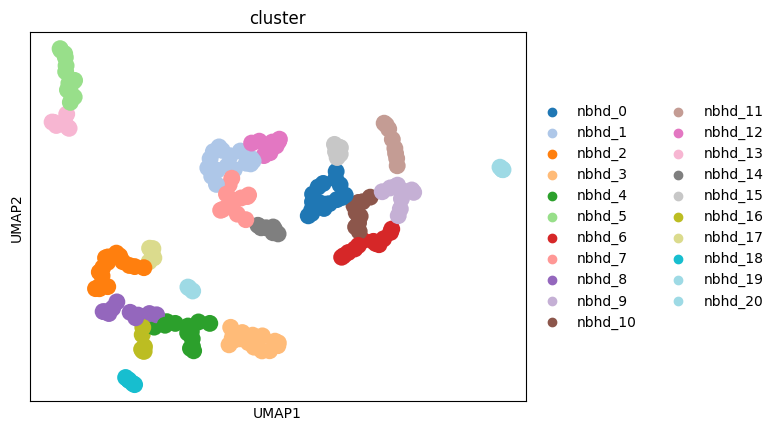

In [120]:
sc.pl.umap(adata, color='cluster', palette='tab20')

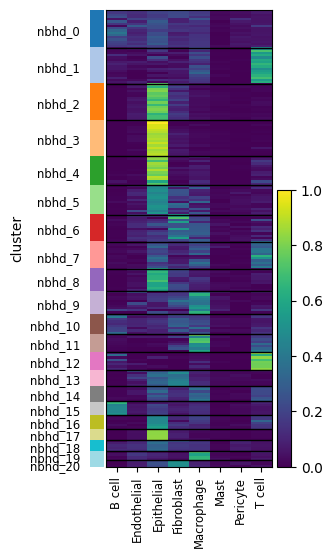

In [121]:
sc.pl.heatmap(adata, var_names=adata.var.index, groupby='cluster')

In [122]:
mapping = {
    'Epithelial': [3, 2, 4, 17, 8],
    'Epithelial - T cell infiltrated': [7],
    'Epithelial - Fibroblast infiltrated': [20],
    'Epithelial - Macrophage/T cell infiltrated': [14, 16],
    'Epithelial - Macrophage/Fibroblast infiltrated': [5, 6],
    'Epithelial - Fibroblast infiltrated': [13],
    'T cell': [1, 12],
    'B cell': [15],
    'Mixed Epithelial/Immune/Fibroblast': [0, 18],
    'Macrophage': [9, 11, 19],
    'Mixed Immune/Fibroblast': [10],
    'Fibroblast': [20],
}
r_mapping = {v:k for k, vs in mapping.items() for v in vs}
adata.obs['integrated_nbhd'] = [r_mapping[int(x.split('_')[-1])] for x in adata.obs['cluster']]

... storing 'integrated_nbhd' as categorical


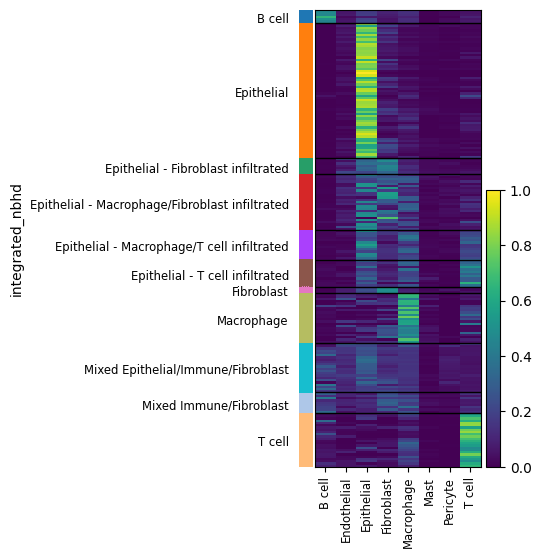

In [123]:
sc.pl.heatmap(adata, var_names=adata.var.index, groupby='integrated_nbhd', )

In [124]:
adata.write_h5ad(output_dir / f'integrated_xenium.h5ad')

###### cosmx

In [229]:
cts = ['Endothelial', 'Epithelial', 'Fibroblast', 'Macrophage', 'T cell']

dtype_to_df = {}
for fp in fps:
    dtype = re.sub(r'^.*celltypes_(.*).txt.gz', r'\1', fp)
    dtype_to_df[dtype] = pd.read_csv(fp, index_col=0, sep='\t')

stacked = []
for dtype, df in dtype_to_df.items():
    df.index = [f'{dtype}_{x}' for x in df.index]
    df = df[cts]
    
    # df /= df.values.sum(1, keepdims=True)
    stacked.append(df)
combined = pd.concat(stacked)
combined = combined[pd.isnull(combined).sum(1) != len(cts)]
combined[pd.isnull(combined)] = 0
# totals = combined.sum(1)
# combined = combined[combined.sum(1) > 5]


adata = anndata.AnnData(X=combined.values)
adata.var.index = combined.columns
adata.obs.index = combined.index.to_list()

adata.X /= adata.X.sum(1, keepdims=True) + .0001
adata.obs['case'] = [x.split('_')[0] for x in adata.obs.index.to_list()]
adata.obs['nbhd'] = [x.split('_')[1] for x in adata.obs.index.to_list()]

sc.pp.neighbors(adata, n_neighbors=3)
sc.tl.leiden(adata, resolution=1.)
adata.obs['cluster'] = [f'nbhd_{x}' for x in adata.obs['leiden']]
sc.tl.umap(adata)
adata
    

/data/estorrs/miniconda3/envs/mushroom_v2/lib/python3.10/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


AnnData object with n_obs × n_vars = 563 × 5
    obs: 'case', 'nbhd', 'leiden', 'cluster'
    uns: 'neighbors', 'leiden', 'umap'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [230]:
import sklearn
clf = sklearn.cluster.KMeans(n_clusters=25)
preds = clf.fit_predict(adata.X)
adata.obs['cluster'] = [str(x) for x in preds]

... storing 'case' as categorical
... storing 'nbhd' as categorical
... storing 'cluster' as categorical


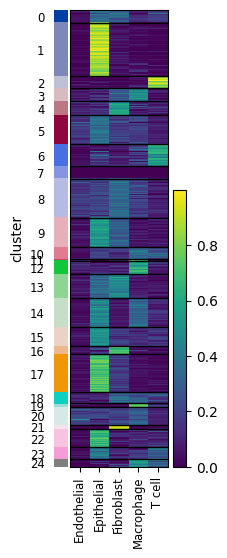

In [231]:
sc.pl.heatmap(adata, var_names=adata.var.index, groupby='cluster')

In [241]:
# mapping = {
#     'Epithelial': [0, 5, 14, 10, 15, 21],
#     'Epithelial - T cell infiltrated': [1],
#     'Epithelial - Fibroblast infiltrated': [2, 16],
#     'Epithelial - Macrophage infiltrated': [7, 24],
#     'Epithelial - Mixed infiltrated': [],
#     'T cell': [3, 13],
#     'Endothelial': [8],
#     'Epi/Macro/Fibro': [12, 17, 19, 20],
#     'Macro/Fibro': [],
#     'Macrophage': [6, 23],
#     'Macro/T/Fibro': [18],
#     'Fibroblast': [4, 9, 11],
#     'Fibro/Macro': [],
#     'Macro/T': [22],
# }
# r_mapping = {v:k for k, vs in mapping.items() for v in vs}
# adata.obs['integrated_nbhd'] = [r_mapping[int(x.split('_')[-1])] for x in adata.obs['cluster']]

mapping = {k:k for k in sorted(set(adata.obs['cluster']))}

adata.obs['integrated_nbhd'] = adata.obs['cluster']

adata = adata[adata.obs['integrated_nbhd']!='Other']

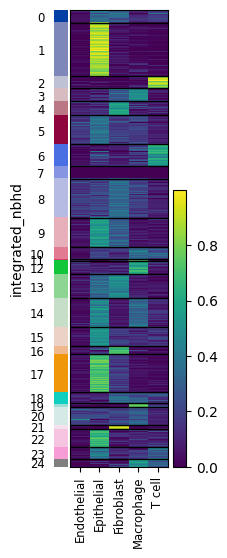

In [233]:
sc.pl.heatmap(adata, var_names=adata.var.index, groupby='integrated_nbhd')

In [234]:
nbhd_mapping = {x:nbhd for x, nbhd in zip(adata.obs.index.to_list(), adata.obs['integrated_nbhd'])}
nbhd_mapping

{'cosmx_HT704B1_0': '5',
 'cosmx_HT704B1_1': '5',
 'cosmx_HT704B1_10': '8',
 'cosmx_HT704B1_11': '5',
 'cosmx_HT704B1_12': '5',
 'cosmx_HT704B1_13': '8',
 'cosmx_HT704B1_14': '5',
 'cosmx_HT704B1_15': '8',
 'cosmx_HT704B1_16': '8',
 'cosmx_HT704B1_17': '18',
 'cosmx_HT704B1_18': '4',
 'cosmx_HT704B1_19': '8',
 'cosmx_HT704B1_2': '5',
 'cosmx_HT704B1_20': '4',
 'cosmx_HT704B1_21': '8',
 'cosmx_HT704B1_22': '8',
 'cosmx_HT704B1_23': '5',
 'cosmx_HT704B1_24': '8',
 'cosmx_HT704B1_25': '5',
 'cosmx_HT704B1_26': '8',
 'cosmx_HT704B1_27': '8',
 'cosmx_HT704B1_3': '8',
 'cosmx_HT704B1_4': '5',
 'cosmx_HT704B1_5': '15',
 'cosmx_HT704B1_6': '8',
 'cosmx_HT704B1_7': '8',
 'cosmx_HT704B1_8': '5',
 'cosmx_HT704B1_9': '8',
 'multiplex_HT206B1_0': '1',
 'multiplex_HT206B1_1': '3',
 'multiplex_HT206B1_10': '22',
 'multiplex_HT206B1_11': '24',
 'multiplex_HT206B1_12': '24',
 'multiplex_HT206B1_13': '14',
 'multiplex_HT206B1_14': '14',
 'multiplex_HT206B1_15': '14',
 'multiplex_HT206B1_16': '14',
 'mul

In [242]:
order = list(mapping.keys())
pal = sns.color_palette('tab20') + sns.color_palette('tab20b')
cmap = {k:pal[i] for i, k in enumerate(order)}


In [243]:
cmap

{'0': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 '1': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 '10': (1.0, 0.4980392156862745, 0.054901960784313725),
 '11': (1.0, 0.7333333333333333, 0.47058823529411764),
 '12': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 '13': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 '14': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 '15': (1.0, 0.596078431372549, 0.5882352941176471),
 '16': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 '17': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 '18': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 '19': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 '2': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 '20': (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 '21': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 '22': (

In [1]:
for case in case_order:
    print(case)
    data = pickle.load(
        open(project_dir / case / 'mushroom_50res' / f'outputs.pkl', 'rb')
    )
    for dtype, labeled in data['dtype_to_clusters'].items():
        if dtype in ['multiplex', 'xenium', 'visium', 'cosmx']:
            labeled = labeled[-1]
            for x in labeled:
                rgb = np.zeros((x.shape[0], x.shape[1], 3))
                pool = np.unique(x)
                nbhds = [f'{dtype}_{case}_{c}' for c in pool]
                for idx, nbhd in zip(pool, nbhds):
                    identifier = nbhd_mapping.get(nbhd)
                    if identifier is not None:
                        m = x==idx
                        rgb[m] = cmap[identifier]
                        # rgb[m] = pal[idx]
                plt.imshow(rgb)
                plt.title(f'{case}_{dtype}')
                plt.show()
                
                
        

In [201]:
data['dtype_to_clusters']

{'integrated': [array([[[12, 12, 12, ..., 12, 12, 12],
          [12, 10, 10, ..., 10, 12, 12],
          [12, 10, 10, ..., 10, 12, 12],
          ...,
          [12, 10, 10, ..., 10, 12, 12],
          [12, 10, 10, ..., 10, 12, 12],
          [12, 12, 12, ..., 12, 12, 12]],
  
         [[12, 12, 12, ..., 12, 12, 12],
          [12, 10, 10, ..., 10, 12, 12],
          [12, 10, 10, ..., 10, 12, 12],
          ...,
          [12, 10, 10, ..., 10, 12, 12],
          [12, 10, 10, ..., 10, 12, 12],
          [12, 12, 12, ..., 12, 12, 12]],
  
         [[12, 12, 12, ..., 12, 12, 12],
          [12, 10, 10, ..., 10, 12, 12],
          [12, 10, 10, ..., 10, 12, 12],
          ...,
          [12, 10, 10, ..., 10, 12, 12],
          [12, 10, 10, ..., 10, 12, 12],
          [12, 12, 12, ..., 12, 12, 12]],
  
         ...,
  
         [[12, 12, 12, ..., 12, 12, 12],
          [12, 10, 10, ..., 10, 12, 12],
          [12, 10, 10, ..., 10, 12, 12],
          ...,
          [12, 10, 10, ..., 10, 12, 

In [157]:
df = dtype_to_df['multiplex']
adata = process_adata(df, 'multiplex')
adata

AnnData object with n_obs × n_vars = 244 × 6
    obs: 'case', 'nbhd', 'leiden', 'cluster'
    uns: 'neighbors', 'leiden', 'umap'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

... storing 'case' as categorical
... storing 'nbhd' as categorical
... storing 'cluster' as categorical


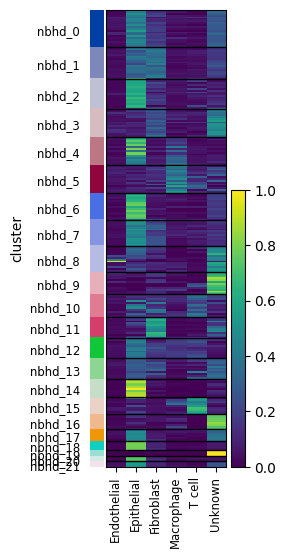

In [158]:
sc.pl.heatmap(adata, var_names=adata.var.index, groupby='cluster')

In [ ]:
mapping = {
    'Epithelial': [],
    'Epithelial - T cell infiltrated': [],
    'Epithelial - Fibroblast infiltrated': [],
    'Epithelial - Macrophage/T cell infiltrated': [],
    'Epithelial - Macrophage/Fibroblast infiltrated': [],
    'Epithelial - Fibroblast infiltrated': [],
    'T cell': [],
    'B cell': [],
    'Mixed Epithelial/Immune/Fibroblast': [],
    'Macrophage': [],
    'Mixed Immune/Fibroblast': [],
    'Fibroblast': [],
}
r_mapping = {v:k for k, vs in mapping.items() for v in vs}
adata.obs['integrated_nbhd'] = [r_mapping[int(x.split('_')[-1])] for x in adata.obs['cluster']]

In [1451]:
common = dtype_to_df['xenium'].columns[~(pd.isnull(dtype_to_df['xenium']).sum(0) > 0)]
counts = dtype_to_df['xenium'][common].sum(1)
counts

group
HT206B1_0     1310.957110
HT206B1_1     1490.900191
HT206B1_10    1286.681587
HT206B1_11    1676.478801
HT206B1_12    1228.515161
                 ...     
S18-9906_5     676.208662
S18-9906_6     685.084490
S18-9906_7     215.650796
S18-9906_8     588.085456
S18-9906_9     847.891084
Length: 212, dtype: float64

In [1452]:
from sklearn.impute import KNNImputer

def impute_values(X):
    imputer = KNNImputer(n_neighbors=5, weights="uniform")
    return imputer.fit_transform(X)

In [1453]:
adata = anndata.AnnData(X=impute_values(dtype_to_df['xenium'].values))
adata.var.index = dtype_to_df['xenium'].columns
adata.obs.index = dtype_to_df['xenium'].index.to_list()
adata.obs['case'] = [x.split('_')[0] for x in adata.obs.index.to_list()]
adata.obs['nbhd'] = [x.split('_')[1] for x in adata.obs.index.to_list()]
adata.obs['density'] = counts.to_list()
sc.pp.scale(adata, zero_center=False)
adata

AnnData object with n_obs × n_vars = 212 × 5228
    obs: 'case', 'nbhd', 'density'
    var: 'mean', 'std'

In [1454]:
import scanpy.external as sce
sc.pp.pca(adata)
sce.pp.harmony_integrate(adata, 'case')
sc.pp.neighbors(adata, n_neighbors=3, use_rep='X_pca_harmony')
sc.tl.leiden(adata, resolution=2.)
adata.obs['cluster'] = [f'nbhd_{x}' for x in adata.obs['leiden']]
sc.tl.umap(adata)

2024-10-28 15:26:33,485 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-10-28 15:26:33,631 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-10-28 15:26:33,632 - harmonypy - INFO - Iteration 1 of 10
2024-10-28 15:26:33,696 - harmonypy - INFO - Iteration 2 of 10
2024-10-28 15:26:33,746 - harmonypy - INFO - Iteration 3 of 10
2024-10-28 15:26:33,780 - harmonypy - INFO - Converged after 3 iterations
/data/estorrs/miniconda3/envs/mushroom_v2/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [1455]:
adata.X[pd.isnull(dtype_to_df['xenium'].values)] = np.nan

<Axes: xlabel='density', ylabel='Count'>

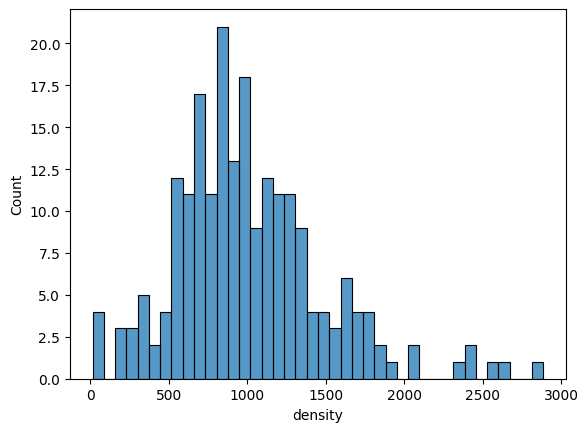

In [1456]:
sns.histplot(adata.obs['density'], bins=40)

In [1457]:
adata.obs['is_background'] = ['yes' if x < 250 else 'no' for x in adata.obs['density']]
adata.obs['cluster'] = ['background' if x == 'yes' else c for x, c in zip(adata.obs['is_background'], adata.obs['cluster'])]

... storing 'case' as categorical
... storing 'nbhd' as categorical
... storing 'cluster' as categorical
... storing 'is_background' as categorical


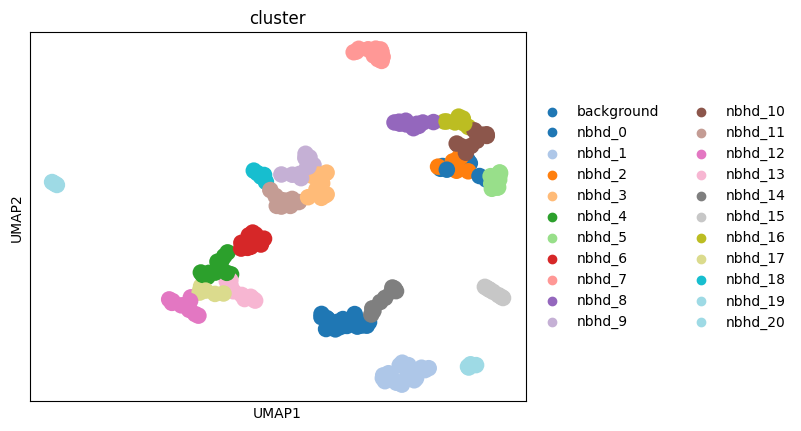

In [1458]:
sc.pl.umap(adata, color='cluster', palette='tab20')

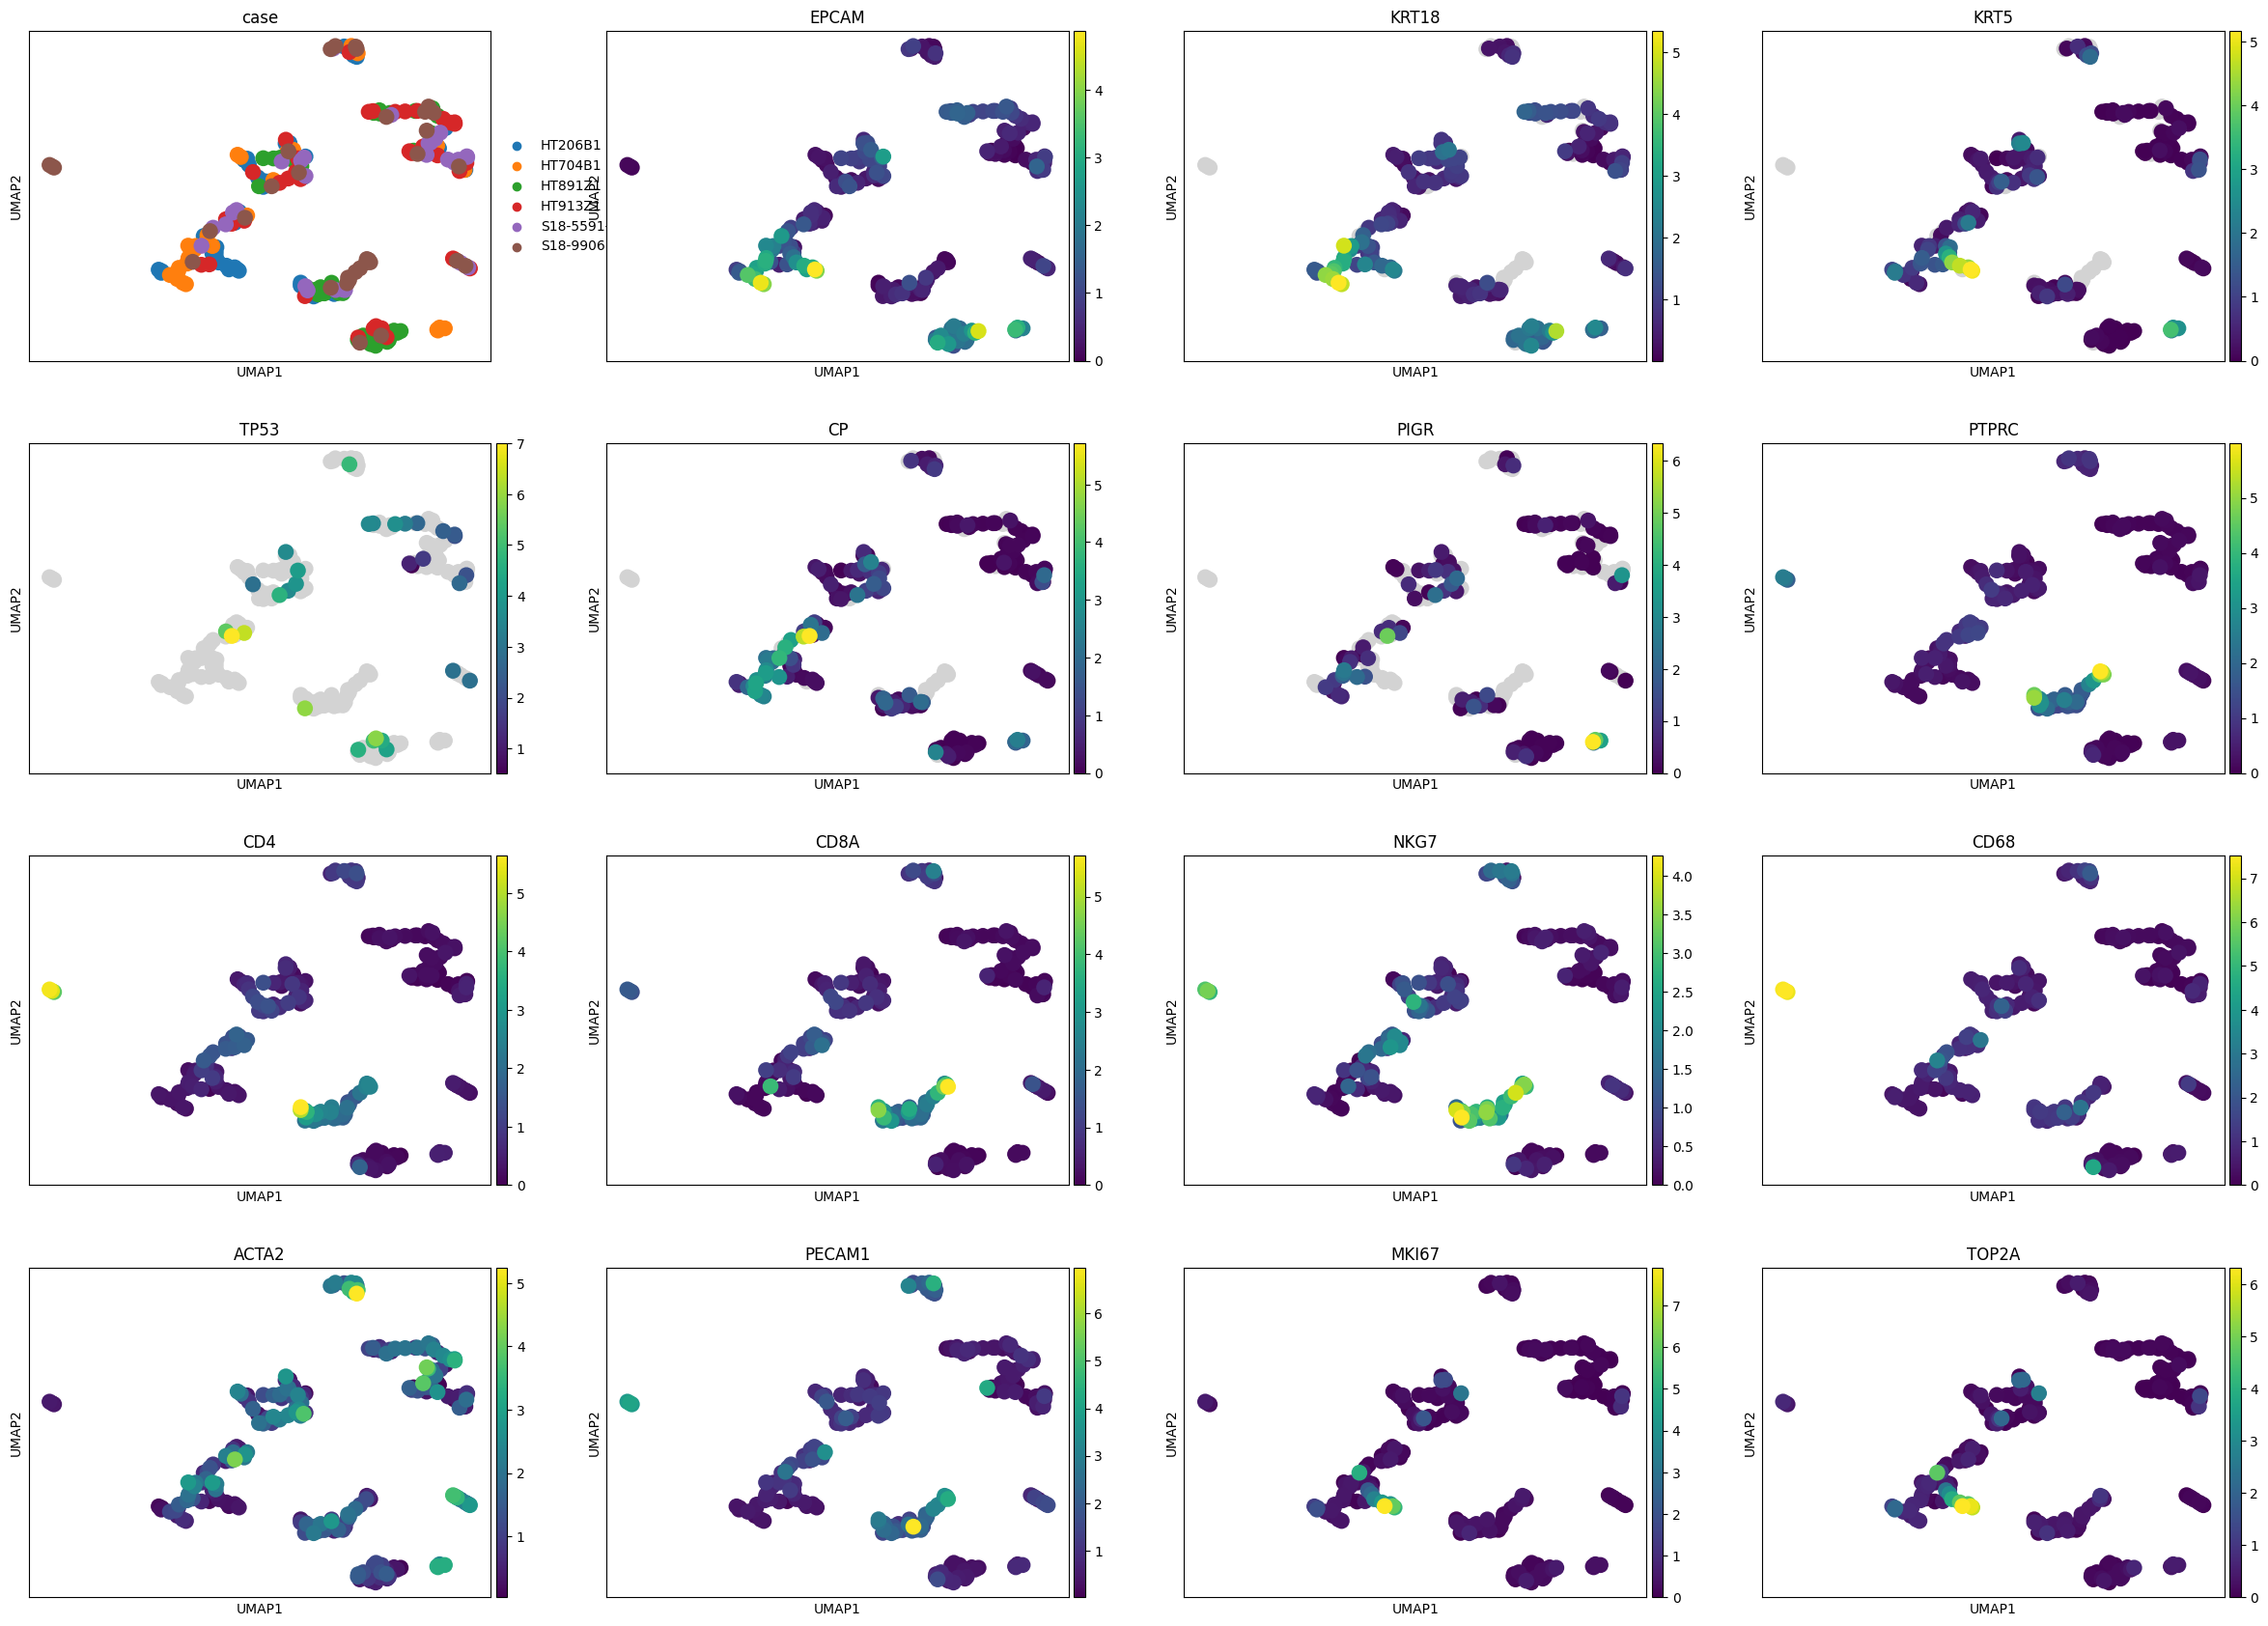

In [1459]:
genes = [
    'EPCAM',
    'KRT18',
    'KRT5',
    'TP53',
    'CP',
    'PIGR',
    'PTPRC',
    'CD4',
    'CD8A',
    'NKG7',
    'CD68',
    'ACTA2',
    'PECAM1',
    'MKI67',
    'TOP2A'
]

sc.pl.umap(adata, color=['case'] + genes)

In [1460]:
macro_genes = {
    'Epithelial': ['EPCAM', 'KRT5', 'KRT18', 'TP53'],
    'Immune': ['PTPRC', 'CD4', 'CD8A', 'CD68', 'CD3E'],
    'Stromal': ['ACTA2', 'VIM']
}

cuts = {
    'Epithelial': .5,
    'Immune': .25,
    'Stromal': 1.,
}

for k, vs in macro_genes.items():
    adata.obs[f'{k}_score'] = pd.DataFrame(adata[:, vs].X).mean(1).to_list()

for k, cut in cuts.items():
    adata.obs[f'is_{k}'] = [k if val >= cut else '' for val in adata.obs[f'{k}_score'].to_list()]

adata.obs['macro_cluster'] = [f'/'.join([v for v in vs if v]) for vs in adata.obs[[f'is_{k}' for k in cuts.keys()]].values]
adata.obs['macro_cluster'] = [x if c != 'background' else 'background' for c, x in adata.obs[['cluster', 'macro_cluster']].values]

... storing 'is_Epithelial' as categorical
... storing 'is_Immune' as categorical
... storing 'is_Stromal' as categorical
... storing 'macro_cluster' as categorical


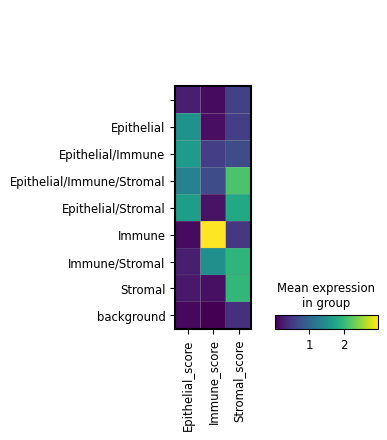

In [1461]:
sc.pl.matrixplot(adata, [c for c in adata.obs.columns if 'score' in c], groupby='macro_cluster')

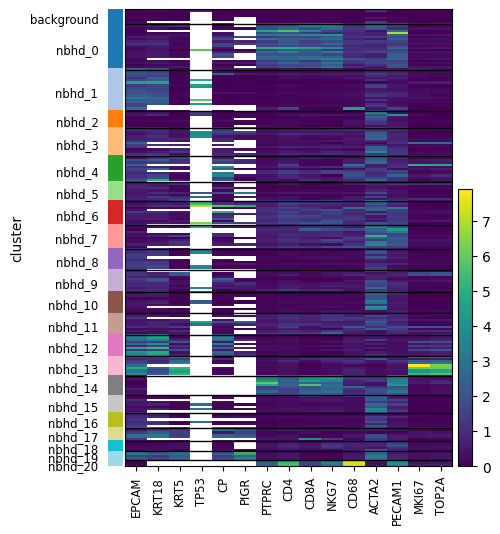

In [1462]:
sc.pl.heatmap(adata, genes, groupby='cluster')

In [1463]:
mapping = {
    'Epithelial': [1, 12, 13],
    'Immune': [0, 14, 20],
    'Stromal': [15, 16, 10],
    'Epithelial/Immune': [],
    'Epithelial/Stromal': [],
    'Immune/Stromal': [],
}


In [1464]:
# dtype_to_df_scaled = {}
# for dtype, df in dtype_to_df.items():
#     print(dtype)
#     df['case'] = [x.split('_')[0] for x in df.index.to_list()]
#     stds = df.groupby('case').std()
#     case_to_stds = {case:vs for case, vs in zip(stds.index.to_list(), stds.values)}
#     new_data = [vals / (case_to_stds[case] + 1e-16) for case, vals in zip(df['case'], df.values[:, :-1])]
#     scaled = pd.DataFrame(data=new_data, columns=df.columns[:-1], index=df.index.to_list())
#     dtype_to_df_scaled[dtype] = scaled
    

In [1465]:
# dtype_order = [
#     'xenium',
#     'multiplex',
#     'cosmx',
#     'visium',
# ]

In [1466]:
# [c for c in dtype_to_df['xenium'] if 'HLA' in c]

In [1467]:
# for dtype, df in dtype_to_df.items():
#     if 'PDCD1' in df.columns:
#         print(dtype)

In [1468]:
# mapping = {
#     'HLA': {
#         'xenium': 'HLA-DQB2',
#         'cosmx': 'HLA-DRA',
#         'visium': 'HLA-DQB2',
#         'vishd': 'HLA-DQB2',
#         'multiplex': 'hla-dr',
#     },
#     'CD3E': {
#         'xenium': 'CD3E',
#         'cosmx': 'CD3E',
#         'visium': 'CD3E',
#         'vishd': 'CD3E',
#         'multiplex': 'cd3e'
#     },
#     'CD4': {
#         'xenium': 'CD4',
#         'cosmx': 'CD4',
#         'visium': 'CD4',
#         'vishd': 'CD4',
#         'multiplex': 'cd4'
#     },
#     'CD8A': {
#         'xenium': 'CD8A',
#         'cosmx': 'CD8A',
#         'visium': 'CD8A',
#         'vishd': 'CD8A',
#         'multiplex': 'cd8'
#     },
#     'PTPRC': {
#         'xenium': 'PTPRC',
#         'cosmx': 'PTPRC',
#         'visium': 'PTPRC',
#         'vishd': 'PTPRC',
#         'multiplex': 'cd45'
#     },
#     'MS4A1': {
#         'xenium': 'MS4A1',
#         'cosmx': 'MS4A1',
#         'visium': 'MS4A1',
#         'vishd': 'MS4A1',
#         'multiplex': 'cd20'
#     },
#     'CD68': {
#         'xenium': 'CD68',
#         'cosmx': 'CD68',
#         'visium': 'CD68',
#         'vishd': 'CD68',
#         'multiplex': 'cd68'
#     },
#     'CD163': {
#         'xenium': 'CD163',
#         'cosmx': 'CD163',
#         'visium': 'CD163',
#         'vishd': 'CD163',
#         'multiplex': 'cd163'
#     },
#     # 'LAG3': {
#     #     'xenium': 'LAG3',
#     #     'cosmx': 'LAG3',
#     #     'visium': 'LAG3',
#     #     'vishd': 'LAG3',
#     # },
#     'NKG7': {
#         'xenium': 'NKG7',
#         'cosmx': 'NKG7',
#         'visium': 'NKG7',
#         'vishd': 'NKG7',
#     },
#     # 'PDCD1': {
#     #     'xenium': 'PDCD1',
#     #     'cosmx': 'PDCD1',
#     #     'visium': 'PDCD1',
#     #     'vishd': 'PDCD1',
#     # },
#     'EPCAM': {
#         'xenium': 'EPCAM',
#         'cosmx': 'EPCAM',
#         'visium': 'EPCAM',
#         'vishd': 'EPCAM',
#         'multiplex': 'e-cadherin'
#     },
#     'PanCK': {
#         'multiplex': 'pan-cytokeratin'
#     },
#     'KRT5': {
#         'xenium': 'KRT5',
#         'cosmx': 'KRT5',
#         'visium': 'KRT5',
#         'vishd': 'KRT5',
#         'multiplex': 'ck5'
#     },
#     'KRT14': {
#         'xenium': 'KRT14',
#         'cosmx': 'KRT14',
#         'visium': 'KRT14',
#         'vishd': 'KRT14',
#         'multiplex': 'ck14'
#     },
#     'KRT18': {
#         'xenium': 'KRT18',
#         'cosmx': 'KRT18',
#         'visium': 'KRT18',
#         'vishd': 'KRT18',
#         'multiplex': 'ck8/18'
#     },
#     # 'TP63': {
#     #     'xenium': 'TP63',
#     #     'visium': 'TP63',
#     #     'vishd': 'TP63',
#     # },
#     # 'CP': {
#     #     'xenium': 'CP',
#     #     'visium': 'CP',
#     #     'vishd': 'cp',
#     # },
#     # 'PIGR': {
#     #     'xenium': 'PIGR',
#     #     'cosmx': 'PIGR',
#     #     'visium': 'PIGR',
#     #     'vishd': 'PIGR',
#     # },
#     'ACTA2': {
#         'xenium': 'ACTA2',
#         'cosmx': 'ACTA2',
#         'visium': 'ACTA2',
#         'vishd': 'ACTA2',
#         'multiplex': 'sma'
#     },
#     # 'PDPN': {
#     #     'xenium': 'PDPN',
#     #     'visium': 'PDPN',
#     #     'vishd': 'PDPN',
#     #     'multiplex': 'podoplanin'
#     # },
#     'PECAM1': {
#         'xenium': 'PECAM1',
#         'cosmx': 'PECAM1',
#         'visium': 'PECAM1',
#         'vishd': 'PECAM1',
#         'multiplex': 'cd31'
#     },
#     'MKI67': {
#         'xenium': 'MKI67',
#         'cosmx': 'MKI67',
#         'visium': 'MKI67',
#         'vishd': 'MKI67',
#         'multiplex': 'ki67'
#     },
#     'TOP2A': {
#         'xenium': 'TOP2A',
#         'cosmx': 'TOP2A',
#         'visium': 'TOP2A',
#         'vishd': 'TOP2A',
#     },
#     # 'VIM': {
#     #     'xenium': 'VIM',
#     #     'cosmx': 'VIM',
#     #     'visium': 'VIM',
#     #     'vishd': 'VIM',
#     #     'multiplex': 'vimentin'
#     # },
# }
# # dtype_to_typing_genes = {
# #     dt:[] for dt in dtype_order
# # }

In [1469]:
# dtype_to_typing_df = {}
# for dt in dtype_order:
#     df = dtype_to_df[dt]
#     cols = {}
#     for gene, d in mapping.items():
#         channel = d.get(dt, None)
#         if channel is not None:
#             cols[gene] = df[channel].to_list()
#         else:
#             cols[gene] = [np.nan] * df.shape[0]
#     typing_df = pd.DataFrame.from_dict(cols)
#     typing_df.index = df.index.to_list()
#     dtype_to_typing_df[dt] = typing_df


In [1470]:
# sns.color_palette('tab20')

In [1471]:
# dt = 'multiplex'
# df = dtype_to_typing_df[dt].copy()
# X = df / df.std(0)

In [1472]:
# cut = .2
# tissue_nbhds = X[X.mean(1) > cut].index.to_list()
# len(tissue_nbhds)

In [1473]:
# n_clusters = 50

# import sklearn
# clustering = sklearn.cluster.KMeans(n_clusters=n_clusters)
# clusters = clustering.fit_transform(X.loc[tissue_nbhds].replace(np.nan, 0)).argmin(1)

# import umap
# u = umap.UMAP()
# x = u.fit_transform(X.loc[tissue_nbhds].replace(np.nan, 0))

# X['umap1'] = [x[tissue_nbhds.index(nbhd), 0] if nbhd in tissue_nbhds else np.nan for nbhd in X.index.to_list()]
# X['umap2'] = [x[tissue_nbhds.index(nbhd), 1] if nbhd in tissue_nbhds else np.nan for nbhd in X.index.to_list()]
# X['cluster'] = [clusters[tissue_nbhds.index(nbhd)] if nbhd in tissue_nbhds else max(clusters) + 1 for nbhd in X.index.to_list()]
# X['case'] = [idx.split('_')[0] for idx in df.index.to_list()]

In [1474]:
cluster_colors = sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c')
macrocluster_colors = sns.color_palette('tab20')

In [1475]:
# from collections import Counter
# Counter(X['cluster'])

In [1476]:
# cluster_df = X.iloc[:, :-1].groupby('cluster').mean().iloc[:, :-2]
# cm = sns.clustermap(cluster_df.replace(np.nan, 0), col_cluster=False, row_cluster=True)
# plt.savefig(output_dir / f'nbhd_clustering_xenium_cg.svg')

In [1477]:
def get_case_to_slice(X, dt, col='cluster'):
    case_to_labeled_slice = {}
    m = {x:i for i, x in enumerate(sorted(set(X[col])))}
    for case in case_order:
        print(case)
        data = pickle.load(
            open(project_dir / case / 'mushroom_50res' / f'outputs.pkl', 'rb')
        )
    
        if dt in data['dtype_to_clusters']:
            labeled = data['dtype_to_clusters'][dt][-1][0]
            new = np.zeros_like(labeled)
        
            for l in np.unique(labeled):
                idx = m[X.loc[f'{case}_{l}', col]]
                new[labeled==l] = idx
        
            case_to_labeled_slice[case] = new
    return case_to_labeled_slice, m

In [1478]:
from matplotlib.patches import Patch
def generate_legend(cmap):
    legend_elements = [
        Patch(facecolor=c, label=l) for l, c in cmap.items()
    ]
    
    # Create the figure
    fig, ax = plt.subplots()
    ax.legend(handles=legend_elements, loc='center')
    ax.set_axis_off()

In [1479]:
def display_on_sections(case_to_labeled_slice, cmap=None):
    fig, axs = plt.subplots(ncols=len(case_to_labeled_slice), figsize=(15, 5))
    for (case, labeled), ax in zip(case_to_labeled_slice.items(), axs):
        rgb = vis_utils.display_labeled_as_rgb(labeled, cmap=cmap)
        ax.imshow(rgb)
        ax.set_title(case)
        ax.set_xticks([])
        ax.set_yticks([])

HT206B1
HT268B1
HT339B2-H1
HT397B1
HT565B1-H2
HT704B1
HT891Z1
HT913Z1
S18-5591-C8
S18-9906


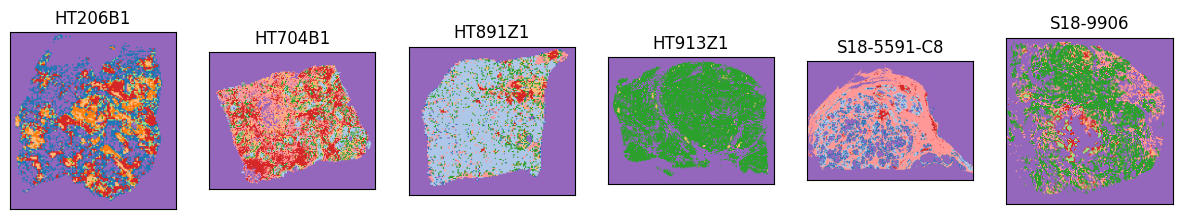

In [1486]:
case_to_labeled_slice, cluster_mapping = get_case_to_slice(adata.obs, 'xenium', col='macro_cluster')
cluster_cmap = {v:cluster_colors[v] for k, v in cluster_mapping.items()}
display_on_sections(case_to_labeled_slice, cmap=cluster_cmap)
plt.savefig(output_dir / f'nbhd_clustering_xenium_onsections.svg')

HT206B1
HT268B1
HT339B2-H1
HT397B1
HT565B1-H2
HT704B1
HT891Z1
HT913Z1
S18-5591-C8
S18-9906


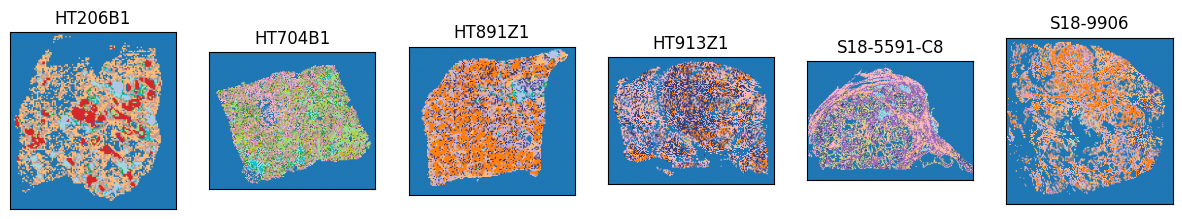

In [1480]:
case_to_labeled_slice, cluster_mapping = get_case_to_slice(adata.obs, 'xenium', col='cluster')
cluster_cmap = {v:cluster_colors[v] for k, v in cluster_mapping.items()}
display_on_sections(case_to_labeled_slice, cmap=cluster_cmap)
plt.savefig(output_dir / f'nbhd_clustering_xenium_onsections.svg')

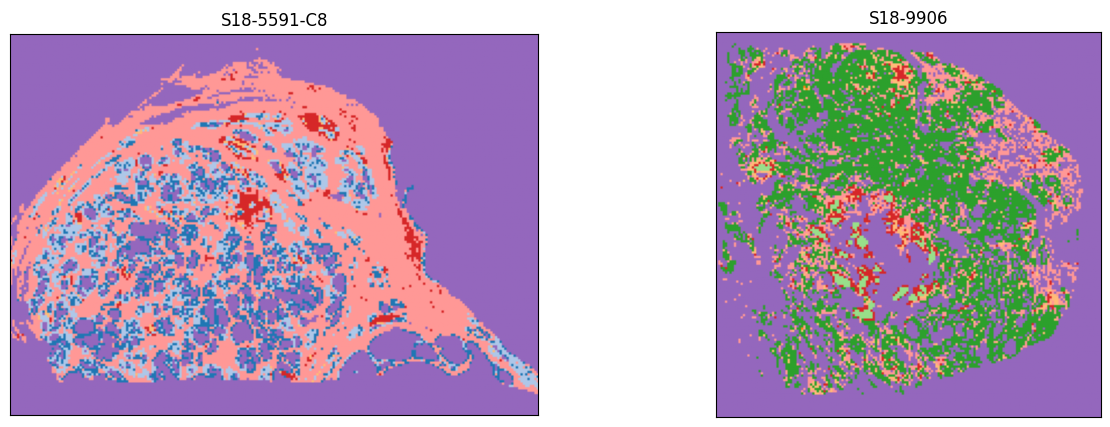

In [1489]:
cs = ['S18-5591-C8', 'S18-9906']
display_on_sections({k:v for k, v in case_to_labeled_slice.items() if k in cs}, cmap=cluster_cmap)

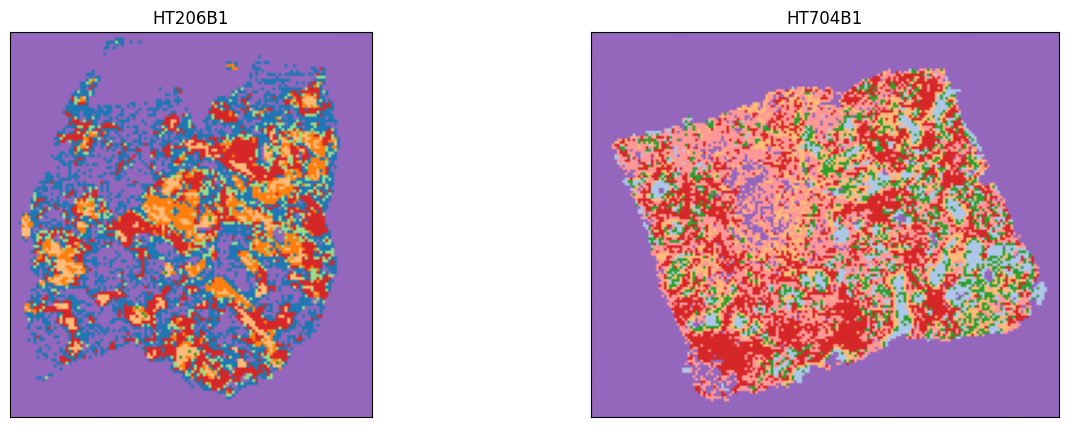

In [1490]:
cs = ['HT206B1', 'HT704B1']
display_on_sections({k:v for k, v in case_to_labeled_slice.items() if k in cs}, cmap=cluster_cmap)

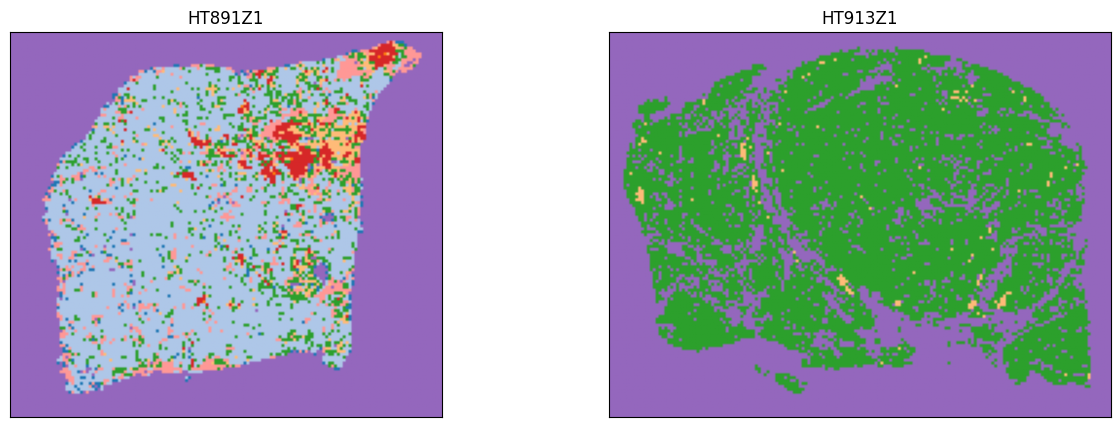

In [1491]:
cs = ['HT913Z1', 'HT891Z1']
display_on_sections({k:v for k, v in case_to_labeled_slice.items() if k in cs}, cmap=cluster_cmap)

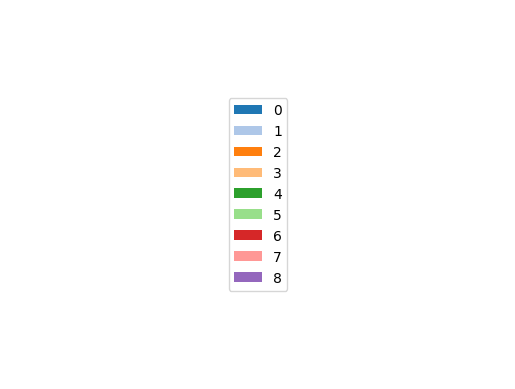

In [1488]:
generate_legend(cluster_cmap)
plt.savefig(output_dir / f'nbhd_clustering_xenium_legend.svg')

In [1487]:
cluster_mapping

{'': 0,
 'Epithelial': 1,
 'Epithelial/Immune': 2,
 'Epithelial/Immune/Stromal': 3,
 'Epithelial/Stromal': 4,
 'Immune': 5,
 'Immune/Stromal': 6,
 'Stromal': 7,
 'background': 8}

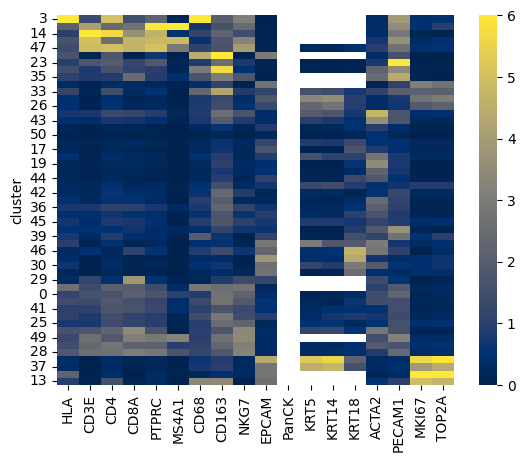

In [1138]:
sns.heatmap(cluster_df.iloc[cm.dendrogram_row.reordered_ind], cmap='cividis', vmax=6.)
plt.yticks(rotation=0)
plt.savefig(output_dir / f'nbhd_clustering_xenium_heatmap.svg')

In [727]:
cluster_mapping = {
    'Epithelial': [0, 8],
    'Basal - Proliferating': [5,9,17,4],
    'Myoepithelial': [6],
    # 'Epithelial/Macrophage': [],
    'Macrophage M1': [10],
    'Macrophage M2': [2],
    'T/NK/B': [7,11],
    'Immune - Mixed': [1,13,14],
    'T/NK': [15],
    'Endothelial': [18,12],
    'Fibroblast': [3,19],
    'Low cellularity/Background': [16],
}
r_mapping = {v:k for k, vs in cluster_mapping.items() for v in vs}
X['macro_cluster'] = [r_mapping[int(c)] for c in X['cluster']]

KeyError: 25

In [728]:
case_to_color = {
    c:sns.color_palette('tab10')[i] for i, c in enumerate(case_order)
}
macrocluster_cmap = {x:sns.color_palette('tab20')[i] for i, x in enumerate(sorted(cluster_mapping))}

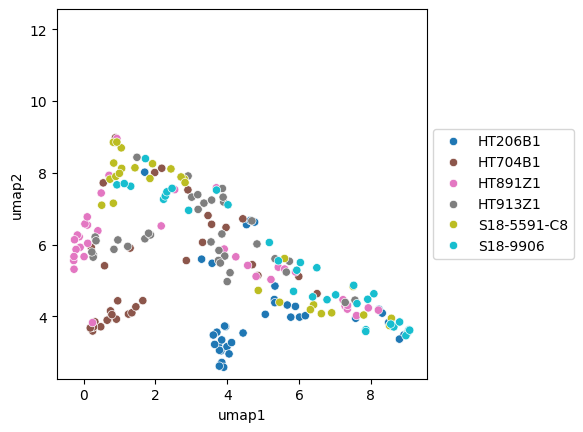

In [729]:
fig, ax = plt.subplots()
sns.scatterplot(data=X, x='umap1', y='umap2', hue='case', palette=case_to_color, ax=ax)
plt.axis('square')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(output_dir / f'nbhd_clustering_xenium_scatterplot_case.svg')

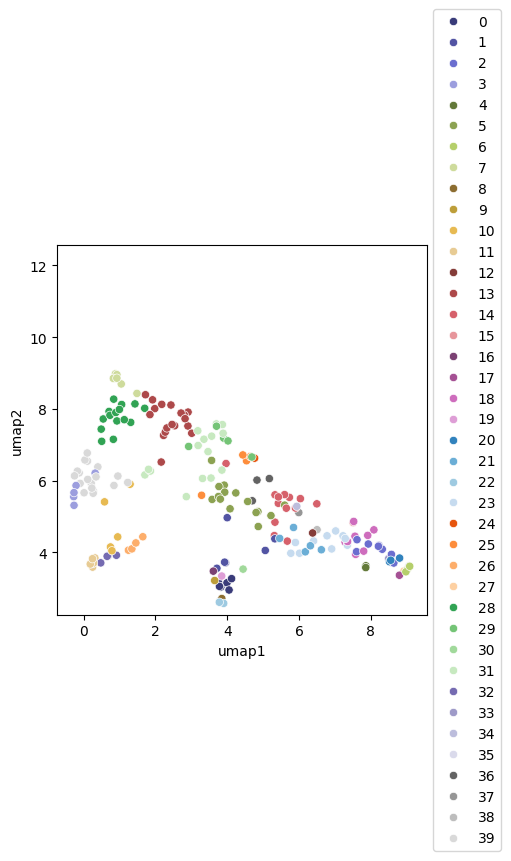

In [730]:
fig, ax = plt.subplots()
sns.scatterplot(data=X, x='umap1', y='umap2', hue='cluster', palette=cluster_cmap, ax=ax)
plt.axis('square')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(output_dir / f'nbhd_clustering_xenium_scatterplot_cluster.svg')

ValueError: Could not interpret value `macro_cluster` for `hue`. An entry with this name does not appear in `data`.

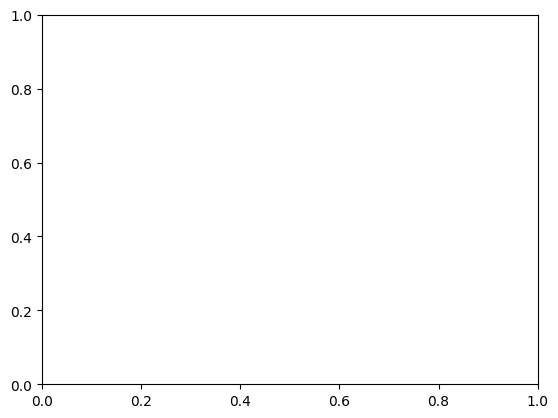

In [713]:
fig, ax = plt.subplots()
sns.scatterplot(data=X, x='umap1', y='umap2', hue='macro_cluster', ax=ax,
                palette=macrocluster_cmap, hue_order=sorted(macrocluster_cmap.keys()))
plt.axis('square')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(output_dir / f'nbhd_clustering_xenium_scatterplot_macrocluster.svg')

/tmp/ipykernel_3533144/1776417134.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=X, x='umap1', y='umap2', hue=col, palette=pallete, ax=ax, legend=None, s=10)


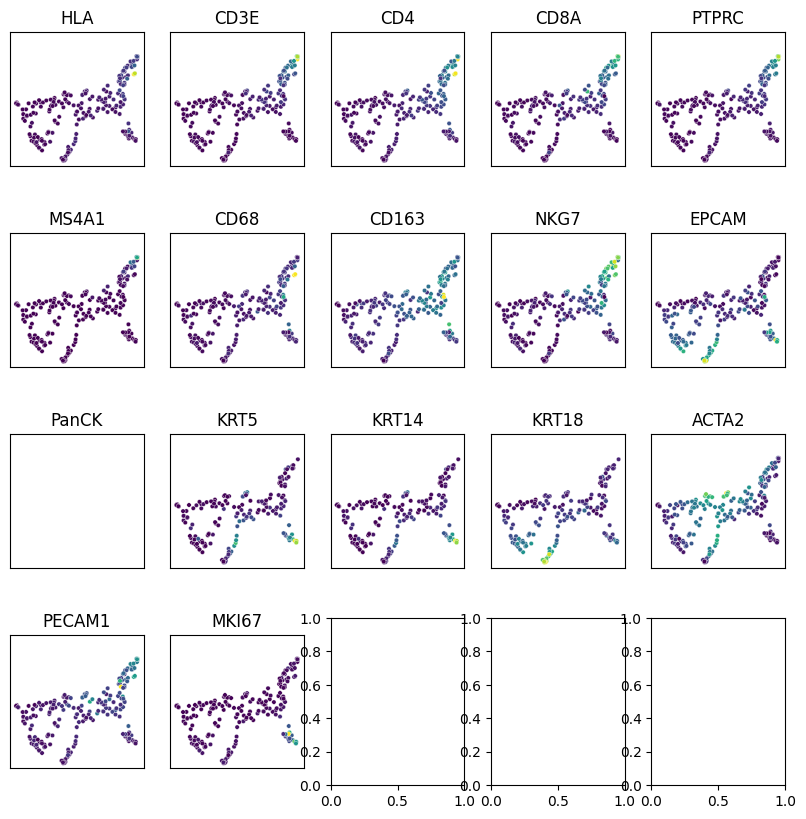

In [714]:
cols = [c for c in X.columns[:-5]]

ncols = 5
nrows = len(cols) // ncols + 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 10))

idxs = rearrange(np.stack(np.meshgrid(np.arange(nrows), np.arange(ncols), indexing='ij')), 'c h w -> (h w) c')

for col, (i, j), ax in zip(cols, idxs, axs.flatten()):
    pallete = 'viridis'
    sns.scatterplot(data=X, x='umap1', y='umap2', hue=col, palette=pallete, ax=ax, legend=None, s=10)
    ax.axis('square')
    ax.set_title(col)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.savefig(output_dir / f'nbhd_clustering_xenium_scatterplot_genes.svg')

In [680]:
cluster_mapping

{'Basal - Proliferating': 0,
 'Endothelial': 1,
 'Epithelial': 2,
 'Fibroblast': 3,
 'Immune - Mixed': 4,
 'Low cellularity/Background': 5,
 'Macrophage M1': 6,
 'Macrophage M2': 7,
 'Myoepithelial': 8,
 'T/NK': 9,
 'T/NK/B': 10}

HT206B1
HT268B1
HT339B2-H1
HT397B1
HT565B1-H2
HT704B1
HT891Z1
HT913Z1
S18-5591-C8
S18-9906


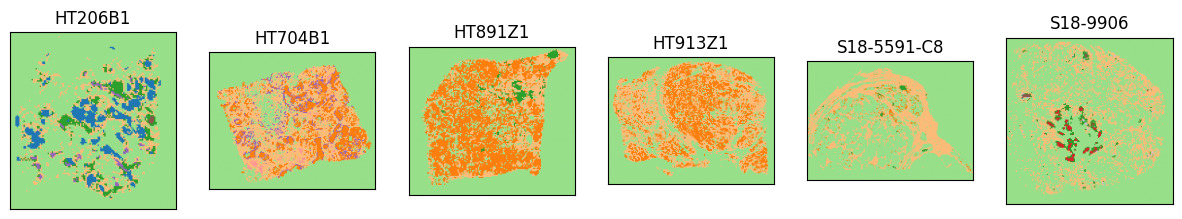

In [684]:
case_to_labeled_slice, cluster_mapping = get_case_to_slice(X, col='macro_cluster')
cmap = {idx:macrocluster_cmap[x] for x, idx in cluster_mapping.items()}
display_on_sections(case_to_labeled_slice, cmap=cmap)
plt.savefig(output_dir / f'nbhd_clustering_xenium_macrocluster_onsection.svg')

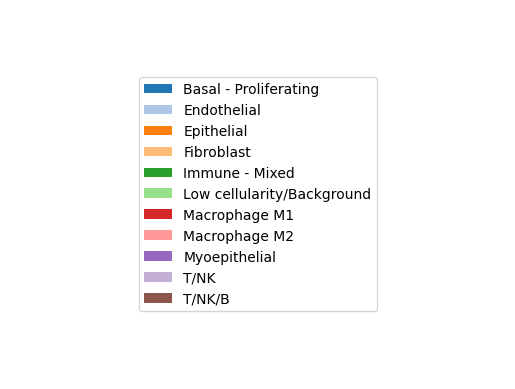

In [686]:
generate_legend(macrocluster_cmap)
plt.savefig(output_dir / f'nbhd_clustering_xenium_macrocluster_legend.svg')